In [1]:
from google.cloud import bigquery
import pandas as pd

# Muestra de datos

In [2]:

master_table = "unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo"

def get_bigquery_data(query) -> pd.DataFrame:
    client = bigquery.Client() 
    query_job = client.query(query)
    return query_job.to_dataframe()

In [3]:
query = f"""
    SELECT *
    FROM {master_table}
    WHERE anio = 2024 AND mes = 6
"""

df = get_bigquery_data(query)

In [4]:
df.count()

fecha                  33725
anio                   33725
mes                    33725
tipo_movimiento_cod    33725
tipo_movimiento        33725
estado_transaccion     33725
cod_pais               33725
nombre_pais            33725
cod_provincia          33725
nombre_provincia       33725
cod_comunidad          33725
nombre_comunidad       33725
nivel_taric            33725
cod_taric              33725
descripcion_taric      33725
euros                  33725
dolares                33725
kilogramos             33725
dtype: int64

In [5]:
df.head()

,fecha,anio,mes,tipo_movimiento_cod,tipo_movimiento,estado_transaccion,cod_pais,nombre_pais,cod_provincia,nombre_provincia,cod_comunidad,nombre_comunidad,nivel_taric,cod_taric,descripcion_taric,euros,dolares,kilogramos
0,2024-06-01,2024,6,E,Exportacion,provisional,504,Perú,00,No determinado,00,No determinado,4,82033000,"Cizallas para metal de mano, de metal común",3505.14,3771.18,19.0
1,2024-06-01,2024,6,E,Exportacion,provisional,504,Perú,00,No determinado,00,No determinado,3,903290,Partes y accesorios,4280.00,4604.85,1.0
2,2024-06-01,2024,6,I,Importacion,provisional,504,Perú,00,No determinado,00,No determinado,5,0810902050,Passion fruit (passiflora edulis),1392.97,1498.70,300.0
3,2024-06-01,2024,6,I,Importacion,provisional,480,Colombia,00,No determinado,00,No determinado,5,0603110000,Rosas,31850.37,34267.81,6057.0
4,2024-06-01,2024,6,E,Exportacion,provisional,504,Perú,00,No determinado,00,No determinado,4,84814010,De fundición o acero,8079.00,8692.20,155.0


In [6]:
df.columns

Index(['fecha', 'anio', 'mes', 'tipo_movimiento_cod', 'tipo_movimiento',
       'estado_transaccion', 'cod_pais', 'nombre_pais', 'cod_provincia',
       'nombre_provincia', 'cod_comunidad', 'nombre_comunidad', 'nivel_taric',
       'cod_taric', 'descripcion_taric', 'euros', 'dolares', 'kilogramos'],
      dtype='object')

In [7]:
query = f"""
    SELECT fecha, anio, mes, tipo_movimiento_cod, cod_pais, 
       cod_taric, dolares, kilogramos
    FROM {master_table}
    where nivel_taric = '1'
"""

df = get_bigquery_data(query)

df.to_csv('comex.csv', index=False, encoding='utf-8', header=True)

In [8]:
df.to_csv('comex.csv', index=False, encoding='utf-8', header=True)

In [9]:
df.count()

fecha                  685994
anio                   685994
mes                    685994
tipo_movimiento_cod    685994
cod_pais               685994
cod_taric              685994
dolares                685994
kilogramos             685994
dtype: int64

# Modelo

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
query = f"""
    SELECT kilogramos, dolares, cod_taric, cod_pais, tipo_movimiento_cod, fecha, anio, mes, cod_provincia, cod_comunidad
    FROM {master_table}
    WHERE nivel_taric = '1'
"""

df = get_bigquery_data(query)

# Ejemplo de transformación logarítmica
#df['dolares'] = np.log1p(df['dolares'])  # log(1 + dolares)
#df['kilogramos'] = np.log1p(df['kilogramos'])


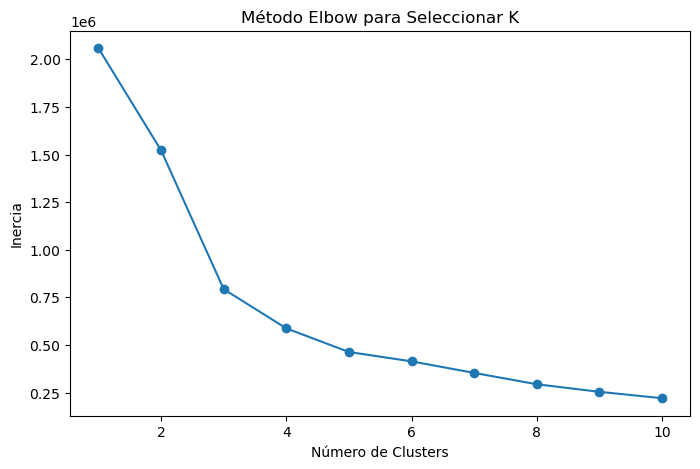

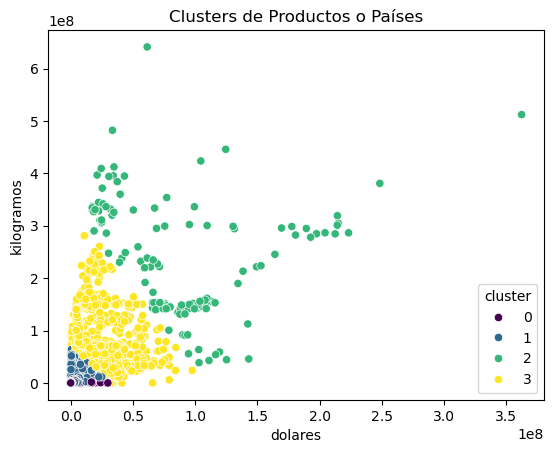

In [12]:

features = df[['dolares', 'kilogramos', 'cod_taric', ]]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método Elbow para Seleccionar K')
plt.show()

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)

sns.scatterplot(data=df, x='dolares', y='kilogramos', hue='cluster', palette='viridis')
plt.title('Clusters de Productos o Países')
plt.show()


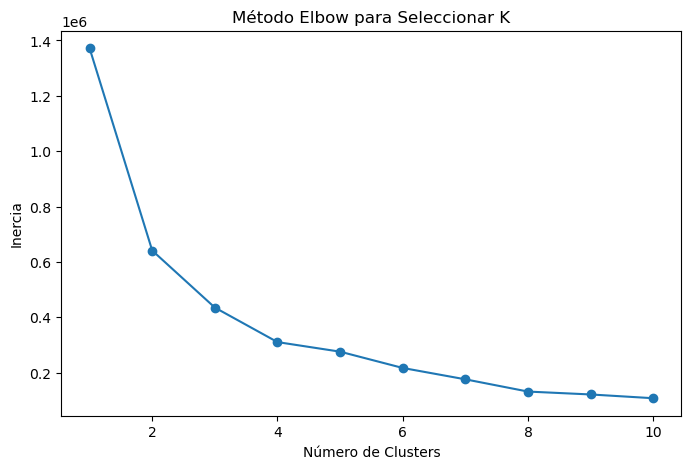

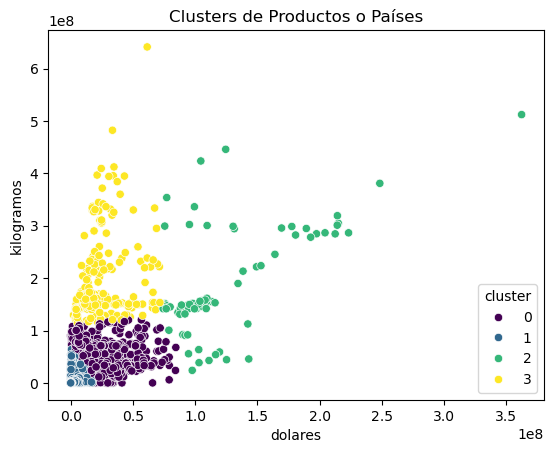

In [13]:
features = df[['dolares', 'kilogramos']]

tipo_movimiento_encoded = pd.get_dummies(df['tipo_movimiento_cod'], prefix='tipo_movimiento_cod')
cod_taric_encoded = pd.get_dummies(df['cod_taric'], prefix='cod_taric')
cod_pais_encoded = pd.get_dummies(df['cod_pais'], prefix='cod_pais')



features = pd.concat([features, tipo_movimiento_encoded], axis=1)
features = pd.concat([features, cod_taric_encoded], axis=1)
features = pd.concat([features, cod_pais_encoded], axis=1)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)


features = df[['dolares', 'kilogramos' ]]


tipo_movimiento_encoded = pd.get_dummies(df['tipo_movimiento_cod'], prefix='tipo_movimiento_cod')

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método Elbow para Seleccionar K')
plt.show()

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)

sns.scatterplot(data=df, x='dolares', y='kilogramos', hue='cluster', palette='viridis')
plt.title('Clusters de Productos o Países')
plt.show()



In [14]:
scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
print(scaled_df.describe())


            dolares    kilogramos
count  6.859940e+05  6.859940e+05
mean   1.575948e-17  7.146921e-18
std    1.000001e+00  1.000001e+00
min   -9.296380e-02 -4.365895e-02
25%   -9.229259e-02 -4.364943e-02
50%   -8.697932e-02 -4.346844e-02
75%   -6.077343e-02 -4.060164e-02
max    1.876492e+02  1.221224e+02


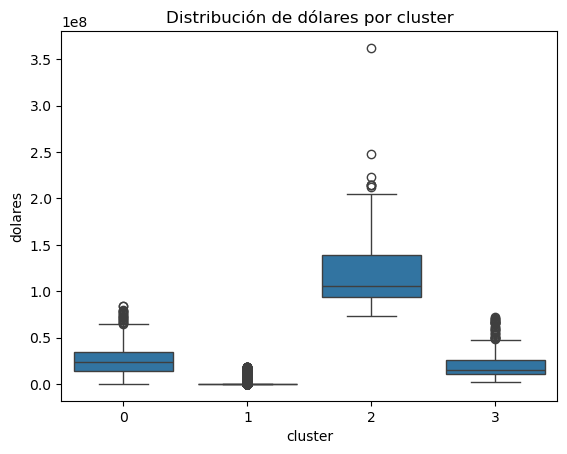

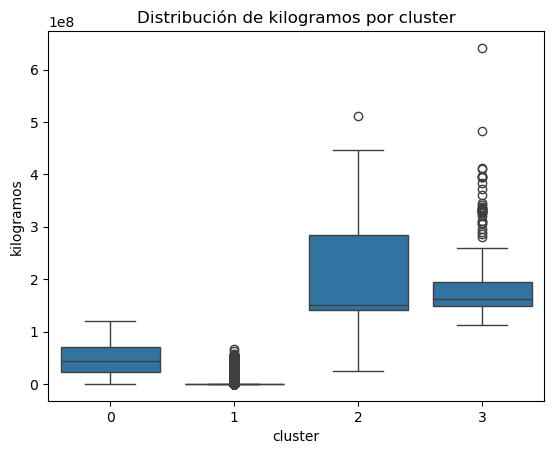

In [15]:
sns.boxplot(data=df, x='cluster', y='dolares')
plt.title('Distribución de dólares por cluster')
plt.show()

sns.boxplot(data=df, x='cluster', y='kilogramos')
plt.title('Distribución de kilogramos por cluster')
plt.show()


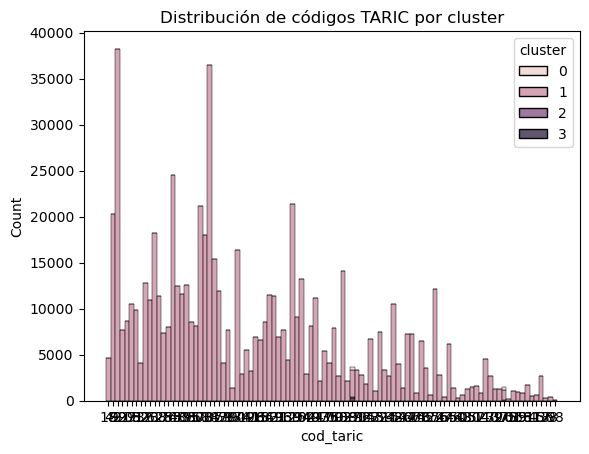

In [16]:
sns.histplot(data=df, x='cod_taric', hue='cluster', multiple='stack', bins=30)
plt.title('Distribución de códigos TARIC por cluster')
plt.show()


# Modelos

In [17]:
data = df.copy()

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

data = data.sort_values(by='fecha')

data['kilogramos_log'] = np.log1p(data['kilogramos'])
data['dolares_log'] = np.log1p(data['dolares'])

features = ['anio', 'mes', 'tipo_movimiento_cod', 'cod_pais', 'cod_provincia', 'cod_comunidad', 'cod_taric']
target_kilogramos = 'kilogramos_log'
target_dolares = 'dolares_log'

label_encoders = {}
for feature in ['tipo_movimiento_cod']:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])
    label_encoders[feature] = le

split_index = int(len(data) * 0.8)
X_train, X_test = data[features][:split_index], data[features][split_index:]
y_train_kilogramos, y_test_kilogramos = data[target_kilogramos][:split_index], data[target_kilogramos][split_index:]
y_train_dolares, y_test_dolares = data[target_dolares][:split_index], data[target_dolares][split_index:]

tree_kilogramos = DecisionTreeRegressor(random_state=42)
tree_kilogramos.fit(X_train, y_train_kilogramos)

tree_dolares = DecisionTreeRegressor(random_state=42)
tree_dolares.fit(X_train, y_train_dolares)

y_pred_kilogramos_log = tree_kilogramos.predict(X_test)
y_pred_dolares_log = tree_dolares.predict(X_test)

y_pred_kilogramos = np.expm1(y_pred_kilogramos_log)
y_test_kilogramos = np.expm1(y_test_kilogramos)

y_pred_dolares = np.expm1(y_pred_dolares_log)
y_test_dolares = np.expm1(y_test_dolares)

mae_kilogramos = mean_absolute_error(y_test_kilogramos, y_pred_kilogramos)
r2_kilogramos = r2_score(y_test_kilogramos, y_pred_kilogramos)

mae_dolares = mean_absolute_error(y_test_dolares, y_pred_dolares)
r2_dolares = r2_score(y_test_dolares, y_pred_dolares)

(mae_kilogramos, r2_kilogramos), (mae_dolares, r2_dolares)


((142072.51233434642, -0.02219103770361608),
 (141990.10598896493, 0.36159847140062595))

Red Neuronal

In [19]:
query = f"""
    SELECT kilogramos, dolares, cod_taric, cod_pais, tipo_movimiento_cod, fecha, anio, mes, cod_provincia, cod_comunidad
    FROM {master_table}
    WHERE nivel_taric = '1' AND anio = 2024
"""

df = get_bigquery_data(query)


In [20]:
data = df.copy()

In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

features = ['anio', 'mes', 'cod_pais', 'cod_provincia', 'cod_comunidad',  'cod_taric']
target_kilogramos = 'kilogramos'
target_dolares = 'dolares'

scaler_features = MinMaxScaler()
scaler_kilogramos = MinMaxScaler()
scaler_dolares = MinMaxScaler()

data[features] = scaler_features.fit_transform(data[features])
data[target_kilogramos] = scaler_kilogramos.fit_transform(data[[target_kilogramos]])
data[target_dolares] = scaler_dolares.fit_transform(data[[target_dolares]])

def create_sequences(data, target, time_steps=6):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

X_kilogramos, y_kilogramos = create_sequences(data[features].values, data[target_kilogramos].values, time_steps=6)

X_dolares, y_dolares = create_sequences(data[features].values, data[target_dolares].values, time_steps=6)

split_index = int(len(X_kilogramos) * 0.8)

X_train_kilogramos, X_test_kilogramos = X_kilogramos[:split_index], X_kilogramos[split_index:]
y_train_kilogramos, y_test_kilogramos = y_kilogramos[:split_index], y_kilogramos[split_index:]

X_train_dolares, X_test_dolares = X_dolares[:split_index], X_dolares[split_index:]
y_train_dolares, y_test_dolares = y_dolares[:split_index], y_dolares[split_index:]

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    return model

print("Entrenando modelo LSTM para kilogramos...")
model_kilogramos = create_lstm_model((X_train_kilogramos.shape[1], X_train_kilogramos.shape[2]))
history_kilogramos = model_kilogramos.fit(
    X_train_kilogramos, y_train_kilogramos,
    epochs=50, batch_size=32, validation_split=0.2, verbose=1
)

print("\nEntrenando modelo LSTM para dólares...")
model_dolares = create_lstm_model((X_train_dolares.shape[1], X_train_dolares.shape[2]))
history_dolares = model_dolares.fit(
    X_train_dolares, y_train_dolares,
    epochs=50, batch_size=32, validation_split=0.2, verbose=1
)

print("\nEvaluando modelo para kilogramos...")
loss_kilogramos, mae_kilogramos = model_kilogramos.evaluate(X_test_kilogramos, y_test_kilogramos, verbose=1)

print("\nEvaluando modelo para dólares...")
loss_dolares, mae_dolares = model_dolares.evaluate(X_test_dolares, y_test_dolares, verbose=1)

print("\nResultados:")
print(f"Kilogramos - Pérdida: {loss_kilogramos:.2f}, MAE: {mae_kilogramos:.2f}")
print(f"Dólares - Pérdida: {loss_dolares:.2f}, MAE: {mae_dolares:.2f}")


Entrenando modelo LSTM para kilogramos...
Epoch 1/50


c:\Users\USUARIO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0049 - mae: 0.0049 - val_loss: 0.0011 - val_mae: 0.0011
Epoch 2/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - mae: 0.0011 - val_loss: 0.0012 - val_mae: 0.0012
Epoch 3/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - mae: 0.0011 - val_loss: 0.0011 - val_mae: 0.0011
Epoch 4/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.2710e-04 - mae: 9.2710e-04 - val_loss: 0.0012 - val_mae: 0.0012
Epoch 5/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.4108e-04 - mae: 9.4108e-04 - val_loss: 0.0011 - val_mae: 0.0011
Epoch 6/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - mae: 0.0011 - val_loss: 0.0011 - val_mae: 0.0011
Epoch 7/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - mae: 0.0014 - val_loss: 0.0011 - val_mae: 0.0011
Epoch 8/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - mae: 0.0011 - val_loss: 0.0012 - val_mae: 0.0012
Epoch 9/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step